In [1]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.ticker as ticker
import seaborn as sns
import helper_fcns as hlp
import autoreload
import os
from scipy.stats import norm, wilcoxon
import statsmodels.api as sm
matplotlib.style.use('plt_style.mplstyle')
%matplotlib inline

Collect/consolidate data for GLM fit. Need trial-by-trial responses, split by contrast and spatial frequency. We will fit one model for each contrast, so we'll need the data consolidated over all spatial frequencies for a given contrast

In [28]:
dataDir = 'data/';
saveDir = dataDir + 'results/';
subj = 2;
disp = 1;
isGeorgeson = 0;
sfFlag = ''; # special modifier for spatial frequency?
# sfFlag = 'sf15'
savePlts = 1;
savePlts_logit = 0;

bootIter = 0; # set to 0 for no bootstrap; for non-logit fit...

pmf_str = 'weibull';

weibull = lambda x, *params: 1 - np.exp(-np.power(x/params[0], params[1]));
true_pmf = lambda params, x: params[3] + (1-params[2]-params[3])*weibull(x, *params[0:2])
# true_pmf = lambda params, x: params[3] + (1-params[2]-params[3])*norm.cdf(x, *params[0:2])

if isGeorgeson:
    whichFiles = 'toAnalyzeS%dD%d%sg.txt' % (subj, disp, sfFlag);
else:
    whichFiles = 'toAnalyzeS%dD%d%s.txt' % (subj, disp, sfFlag);
dataList = open(dataDir + whichFiles, 'r')
dFilesAll = dataList.readlines(-1)
dFilesAll = [x.strip('\n') for x in dFilesAll]
dataList.close()

In [29]:
if not isGeorgeson and subj == 1:
    if disp == 1:
        dFiles = dFilesAll[4:]; # ignore the first 4 sessions - early training
    elif disp == 3:
        dFiles = dFilesAll[1:];
    elif disp == 5:
        dFiles = dFilesAll[2:]; # ignore first 2
else:
    dFiles = dFilesAll;

In [30]:
sfIdx = 0;
conIdx = 1;
dispIdx = 2;
nInd = 3; # 3 indices per stimulus; add 3 to all of the above indices to get the equivalent value for the second stimulus
subjRespIdx = 2*nInd;
refIdx = subjRespIdx + 1; # which interval contained reference is after the subject's response in the data format

In [31]:
stim1 = 39; stim2 = 41; # subject responses (asked if first/left stimulus is of higher frequency than the second/right stimulus)

In [32]:
data = [];
for df in dFiles:
    currData = np.loadtxt(dataDir + df);
    if df == dFiles[0]:
        data = currData;
    else:
        data = np.concatenate((data, currData), axis = 0);

sfVals = np.union1d(np.unique(data[:, sfIdx]), np.unique(data[:, sfIdx+nInd]))
conVals = np.union1d(np.unique(data[:, conIdx]), np.unique(data[:, conIdx+nInd]))
nCons = len(conVals);
dispVals = np.union1d(np.unique(data[:, dispIdx]), np.unique(data[:, dispIdx+nInd]))

In [33]:
allResp = data[:, subjRespIdx];
if any((allResp != stim1) & (allResp != stim2)):
    print('Problem: response which is neither 1 or 2')

In [34]:
s1g = data[:, sfIdx] > data[:, sfIdx+nInd];
s2g = data[:, sfIdx] < data[:, sfIdx+nInd]

In [35]:
# find which one is the reference (as opposed to test) grating
ref = np.zeros(data.shape[0])
ref = data[:, refIdx]

# allows for possibility of more than one refSf...
refSF = np.union1d(np.unique(data[ref==1, sfIdx]), np.unique(data[ref==2, sfIdx+nInd]))

In [36]:
# did the subject perceive the test as higher SF?
testHF = np.zeros(data.shape[0]);
testHF[ref==1] = data[ref==1, subjRespIdx] == stim2;
testHF[ref==2] = data[ref==2, subjRespIdx] == stim1;

In [37]:
testCons = np.zeros(data.shape[0])
testCons[ref==1] = data[ref==1, nInd+conIdx];
testCons[ref==2] = data[ref==2, conIdx];

In [38]:
testSfs = np.zeros(data.shape[0])
testSfs[ref==1] = data[ref==1, nInd+sfIdx];
testSfs[ref==2] = data[ref==2, sfIdx];

In [39]:
checkz = np.zeros((len(testSfs), 1));
for i in range(len(sfVals)):
    checkz[testSfs == sfVals[i]] = 1;

In [40]:
# data analysis - number of trials/responses "test>ref sf", fraction "test>ref" split by sf/con
glmFits = [];
ptSf, nTr, nTestResp = (np.zeros((nCons, len(sfVals))) for _ in range(3));
for con in range(nCons):
    for sf in range(len(sfVals)):
        z = (testSfs == sfVals[sf]) & (testCons == conVals[con]) # get trials with the desired test sf/con
        nTr[con][sf] = sum(z); # how many trials in this configuration
        nTestResp[con][sf] = sum(testHF[z]) # how many trials in this configuration with response "test > ref sf"
        ptSf[con][sf] = nTestResp[con][sf] / nTr[con][sf]
    print('Con ' + str(conVals[con]) + ': ' + str(sum(nTr[con])) + ' trials')

Con 0.04: 200.0 trials
Con 0.08: 176.0 trials
Con 0.16: 180.0 trials
Con 0.32: 194.0 trials


In [41]:
# optimize and bootstrap
nFits = 5; # don't think you need multistart, but build it in anyway
univ_params = 3; # number of "universal parameters", i.e. for all pmf
nParams = nCons + univ_params; # one mean for each contrast; overall slope, lapses
bootTestResps = np.zeros((nCons, len(nTestResp[0]), bootIter))
loss = np.zeros((nCons, 1)); # only one loss value...

opt = hlp.opt_pmf(sfVals, nTestResp, nTr, weibull, nFits);
# opt = hlp.opt_pmf(sfVals, nTestResp, nTr, norm.cdf, nFits);

params = np.zeros((nCons, univ_params+1)) # 3+1 params per PMF
for c in range(nCons): # now unpack...
    params[c, 0] = opt['x'][c];
    params[c, 1] = opt['x'][nCons+c];
    params[c, 2] = opt['x'][2*nCons+c];
    params[c, 3] = opt['x'][3*nCons+c];
    # expand dimensions of nTestResp so that pmf_loss knows there is only one contrast value to explore
    loss[c] = hlp.pmf_loss(sfVals, np.expand_dims(nTestResp[c], 0), np.expand_dims(nTr[c], 0),
                           norm.cdf, params[c, 0], params[c, 1], params[c, 2], params[c, 3]);
    
paramsBoot = np.zeros((nCons, univ_params+1, bootIter));
for iter in range(bootIter):
    bootTestResps[:, :, iter] = np.random.binomial(nTr.astype('int64'), ptSf)
    # expand dimensions of bootTestResps so that pmf_loss knows there is only one contrast value to explore
    optBoot = hlp.opt_pmf(sfVals, bootTestResps[:, :, iter], nTr, norm.cdf, 1)
    # unpack paramters
    for c in range(nCons):
        paramsBoot[c, 0, iter] = optBoot['x'][c];
        paramsBoot[c, 1, iter] = optBoot['x'][nCons+c];
        paramsBoot[c, 2, iter] = optBoot['x'][2*nCons+c];
        paramsBoot[c, 3, iter] = optBoot['x'][3*nCons+c];

In [42]:
# compute from bootstrap values...
bootParamMean = paramsBoot.mean(-1);
bootParamStd = paramsBoot.std(-1);

# reshape number of trials by con/sf so we can get bootstrap estimates of subject's proportion responses "test>ref"
bootPtSf = bootTestResps / np.repeat(nTr.reshape((len(conVals), len(nTestResp[0]), 1)), bootIter, axis=-1); 
bootPtSfmean = bootPtSf.mean(-1);
bootPtSfstd = bootPtSf.std(-1);

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/paulgerald/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/paulgerald/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/paulgerald/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/paulgerald/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:114: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


### Plot of psychometric function and measured responses

In [ ]:
sfVals

In [ ]:
sfRef = 1.5

In [ ]:
[sfRef*(1+i*.05) for i in np.arange(-4, 5, 1)] 

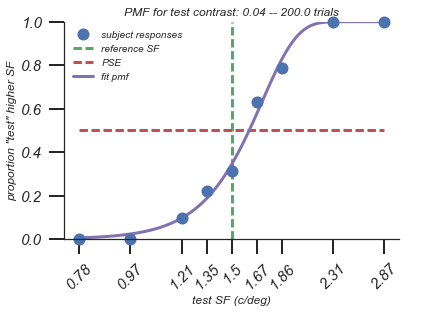

In [43]:
# now plot the PMF
whichCon = 0;
isPmfLog = 0;

curr_params = params[whichCon, :]
#sns.set_style("dark")

if isPmfLog:
    sfValsPlot = np.log2(sfVals);
    refSfPlot = np.log2(refSF);
    pmfPlot = np.log2(np.linspace(sfVals[0], sfVals[-1], 101));
else:
    sfValsPlot = sfVals;
    refSfPlot = refSF;
    pmfPlot = np.linspace(sfVals[0], sfVals[-1], 101);

pts = plt.errorbar(sfValsPlot, ptSf[whichCon], yerr=bootPtSfstd[whichCon, :], clip_on=False, linestyle='none', marker='o');
refSFline = plt.plot([refSfPlot, refSfPlot], [0, 1], '--'); 
pse = plt.plot([sfValsPlot[0], sfValsPlot[-1]], [0.5, 0.5], '--')
pmf = plt.plot(pmfPlot, true_pmf(curr_params, pmfPlot), '-');
if not isPmfLog:
    plt.xscale('log')
plt.ylim([0, 1]);
plt.tick_params(axis='x', which='minor', bottom=False, labelbottom=False); # remove old/original ticks
plt.tick_params(labelsize=15, width=2, length=15, which='major')
sfAsStr = [str(x) for x in np.round(sfVals, 2)];
plt.xticks(sfVals, sfAsStr, rotation='45')
plt.xlabel('test SF (c/deg)');
plt.ylabel('proportion "test" higher SF');
plt.legend((pts[0], refSFline[0], pse[0], pmf[0]), ('subject responses', 'reference SF', 'PSE', 'fit pmf'));
plt.title('PMF for test contrast: ' + str(conVals[whichCon]) + ' -- ' + str(sum(nTr[whichCon])) + ' trials');

### Comparison of two contrasts

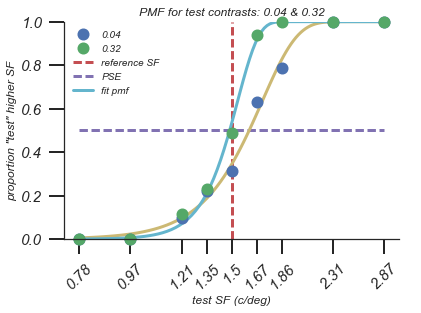

In [44]:
con1 = 0; con2 = 3;
isPmfLog = 0;

params1 = params[con1, :];
params2 = params[con2, :];

if isPmfLog:
    sfValsPlot = np.log2(sfVals);
    refSfPlot = np.log2(refSF);
    pmfPlot = np.log2(np.linspace(sfVals[0], sfVals[-1], 101));
else:
    sfValsPlot = sfVals;
    refSfPlot = refSF;
    pmfPlot = np.linspace(sfVals[0], sfVals[-1], 101);

pts = plt.errorbar(sfValsPlot, ptSf[con1], yerr=bootPtSfstd[con1, :], clip_on=False, linestyle='none', marker='o');
pts2 = plt.errorbar(sfValsPlot, ptSf[con2], yerr=bootPtSfstd[con2, :], clip_on=False, linestyle='none', marker='o');

refSFline = plt.plot([refSfPlot, refSfPlot], [0, 1], '--'); 

pse = plt.plot([sfValsPlot[0], sfValsPlot[-1]], [0.5, 0.5], '--')
pmf = plt.plot(pmfPlot, true_pmf(params1, pmfPlot), '-');
pmf = plt.plot(pmfPlot, true_pmf(params2, pmfPlot), '-');
if not isPmfLog:
    plt.xscale('log')

plt.ylim([0, 1]);
plt.tick_params(axis='x', which='minor', bottom=False, labelbottom=False); # remove old/original ticks
plt.tick_params(labelsize=15, width=2, length=15, which='major')
sfAsStr = [str(x) for x in np.round(sfVals, 2)];
plt.xticks(sfVals, sfAsStr, rotation='45')
plt.xlabel('test SF (c/deg)');
plt.ylabel('proportion "test" higher SF');
plt.legend((pts[0], pts2[0], refSFline[0], pse[0], pmf[0]), (str(conVals[con1]), str(conVals[con2]), 'reference SF', 'PSE', 'fit pmf'));
plt.title('PMF for test contrasts: ' + str(conVals[con1]) + ' & ' + str(conVals[con2]));

### Plot all PMF

In [45]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.style'] = 'oblique'
#rcParams['font.size'] = 20
rcParams['pdf.fonttype'] = 3 # should be 42, but there are kerning issues
rcParams['ps.fonttype'] = 3 # should be 42, but there are kerning issues

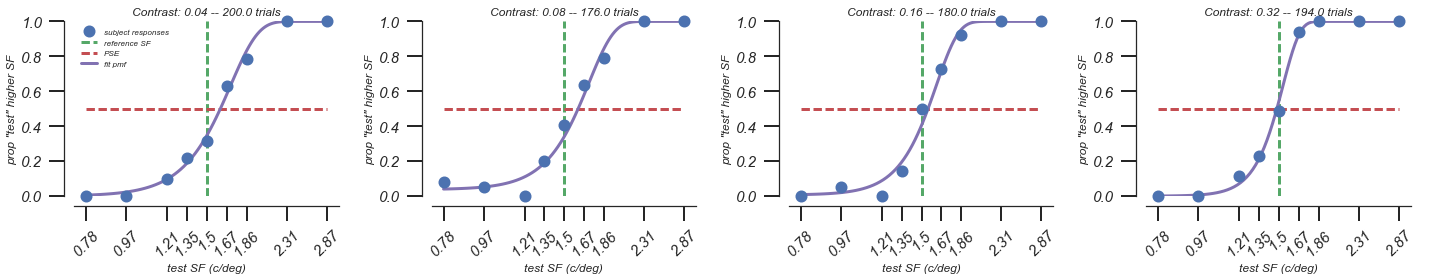

In [46]:
figPMF, allPMF = plt.subplots(1, 4, figsize=(20, 4));
isPmfLog = 0;
# now plot the PMF

sns.set_style('white')
sns.despine(offset=10);

if isPmfLog:
    sfValsPlot = np.log2(sfVals);
    refSfPlot = np.log2(refSF);
    pmfPlot = np.log2(np.linspace(sfVals[0], sfVals[-1], 101));
else:
    sfValsPlot = sfVals;
    refSfPlot = refSF;
    pmfPlot = np.linspace(sfVals[0], sfVals[-1], 101);

for c in range(nCons):
    whichCon = c;

    pts = allPMF[c].errorbar(sfValsPlot, ptSf[whichCon], yerr=bootPtSfstd[whichCon, :], clip_on=False, linestyle='none', marker='o');
    refSFline = allPMF[c].plot([refSfPlot, refSfPlot], [0, 1], '--'); 
    pse = allPMF[c].plot([sfValsPlot[0], sfValsPlot[-1]], [0.5, 0.5], '--')
    pmf = allPMF[c].plot(pmfPlot, true_pmf(params[whichCon, :], pmfPlot), '-');
    
    if not isPmfLog:
        allPMF[c].set_xscale('log')
    
    allPMF[c].set_ylim([0, 1]);
    
    # get the ticks correct
    allPMF[c].tick_params(axis='x', which='minor', bottom=False, labelbottom=False); # remove old/original ticks
    allPMF[c].tick_params(labelsize=15, width=2, length=15, which='major')
    sfAsStr = [str(x) for x in np.round(sfValsPlot, 2)];
    allPMF[c].set_xticks(sfValsPlot);
    allPMF[c].set_xticklabels(sfAsStr, rotation='45');
    
    allPMF[c].set_xlabel('test SF (c/deg)');
    allPMF[c].set_ylabel('prop "test" higher SF');
    allPMF[c].set_title('Contrast: ' + str(conVals[whichCon]) + ' -- ' + str(sum(nTr[whichCon])) + ' trials');
    if c == 0:
        allPMF[c].legend((pts[0], refSFline[0], pse[0], pmf[0]), ('subject responses', 'reference SF', 'PSE', 'fit pmf'), loc='upper left', fontsize=8);

figPMF.tight_layout()

What are the inferred PSEs for each contrast? How about the SF which is perceived at the reference SF?

In [47]:
fit_pse = np.zeros((nCons, 1));
opts = [];
for c in range(nCons):
    fit_pse[c, 0], opts_curr = hlp.find_pse(true_pmf, params[c, :])
    opts.append(opts_curr);
    print('%.2f contrast: PSE is %.3f cpd' % (conVals[c], np.power(2, fit_pse[c, 0])))

0.04 contrast: PSE is 3.059 cpd
0.08 contrast: PSE is 3.068 cpd
0.16 contrast: PSE is 2.936 cpd
0.32 contrast: PSE is 2.797 cpd


### Plot of subject bias and sensitivity

In [48]:
pse = np.zeros((len(conVals), 1));
evalSfs = np.arange(sfVals[0], sfVals[-1], 1e-3);
evalPmf = lambda params: params[2] + (1-2*params[2])*norm.cdf(evalSfs, *params[0:2]);
for con in range(len(conVals)):
    pse[con] = evalSfs[np.argmin(abs(evalPmf(params[con]) - 0.5))]

In [49]:
# Statistics on PSE bootstrapped values...
pOfInt = 0; # PSE
outerInd = len(conVals);
pValPSE = np.nan*np.ones((outerInd, outerInd));
for c in range(outerInd):
    for ci in range(len(conVals) - c-1):
        
        z, pValPSE[c, c+ci+1] = wilcoxon(paramsBoot[c, pOfInt, :], paramsBoot[c+ci+1, pOfInt, :]); # 0 is PSE
        pValPSE[c+ci+1, c] = pValPSE[c, c+ci+1]

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/Users/paulgerald/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2413: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se


In [50]:
print('Significant difference in bootstrap distributions of PSE? P value:')
upTri = np.triu(pValPSE);
np.set_printoptions(precision=4)
np.set_printoptions(suppress=False)
print(upTri)

Significant difference in bootstrap distributions of PSE? P value:
[[ nan  nan  nan  nan]
 [  0.  nan  nan  nan]
 [  0.   0.  nan  nan]
 [  0.   0.   0.  nan]]


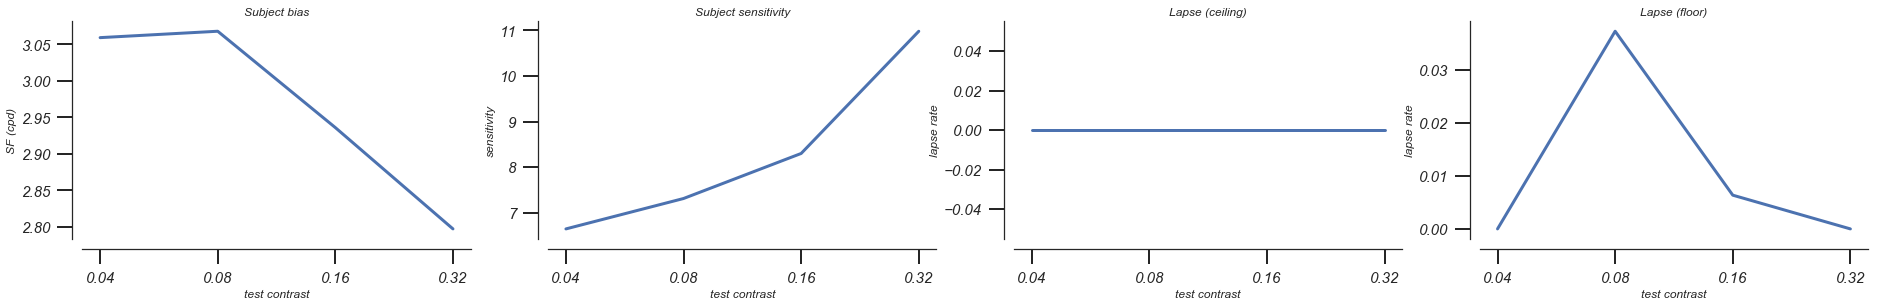

In [51]:
nParams = params.shape[0];
figParams, paramPlot = plt.subplots(1, nParams, figsize=(8*nParams, 4));

sns.set_style('white')
sns.despine(offset=10);

y_labels = ['SF (cpd)', 'sensitivity', 'lapse rate', 'lapse rate']
titles = ['Subject bias', 'Subject sensitivity', 'Lapse (ceiling)', 'Lapse (floor)']

for param_i in range(nParams):
    
    if param_i == 0:
        pse = paramPlot[param_i].errorbar(conVals, np.power(2, fit_pse[:, 0]), bootParamStd[:, param_i]);
    else:
        paramPlot[param_i].errorbar(conVals, params[:, param_i], bootParamStd[:, param_i]);
        
    paramPlot[param_i].tick_params(axis='x', which='minor', bottom=False, labelbottom=False); # remove old/original ticks
    paramPlot[param_i].set_xscale('log');
    paramPlot[param_i].set_xlabel('test contrast');
    paramPlot[param_i].set_ylabel(y_labels[param_i]);
    paramPlot[param_i].set_title(titles[param_i]);
    paramPlot[param_i].tick_params(labelsize=15, width=2, length=15, which='major')
    paramPlot[param_i].set_xticks(conVals);
    conAsStr = [str(x) for x in conVals];
    paramPlot[param_i].set_xticklabels(conAsStr);

# paramPlot[2].text(0.5, 0.55, 'Lapse high: ' + str(np.round(params[0, 2], 3)) + ' +/- ' + 
#                    str(np.round(bootParamStd[0, 1], 3)), horizontalalignment = 'center', verticalalignment = 'center');
# paramPlot[2].text(0.5, 0.45, 'Lapse low: ' + str(np.round(params[0, 3], 3)) + ' +/- ' + 
#                   str(np.round(bootParamStd[0, 2], 3)), horizontalalignment = 'center', verticalalignment = 'center');
# paramPlot[2].set_title('Other parameters');

In [52]:
if savePlts:
    allFigs = [figPMF, figParams];
    if isGeorgeson:
        saveName = "results_%sS%dD%d%sg.pdf" % (pmf_str, subj, disp, sfFlag)
    else:
        saveName = "results_%sS%dD%d%s.pdf" % (pmf_str, subj, disp, sfFlag)
    pdf = pltSave.PdfPages(str(saveDir + saveName))
    for fig in range(len(allFigs)): ## will open an empty extra figure :(
        pdf.savefig(allFigs[fig], bbox_inches="tight")
    pdf.close()

### Now do it with a GLM (logit link)

In [ ]:
sfsPlot = np.logspace(np.log10(sfVals[0]), np.log10(sfVals[-1]), 101)
glmFits = dict();

for c in range(nCons):
    curr_tr = testCons == conVals[c]; # get trials with the desired test sf/con
    resps = testHF[curr_tr];
    sfs = testSfs[curr_tr];

    curr_fit = hlp.fit_pmf_logit(resps, sfs);
    glmFits[c] = dict();
    glmFits[c]['opt'] = curr_fit;
    pse, pse_se, curve = hlp.get_logit_results(curr_fit, eval_sfs=sfsPlot);
    glmFits[c]['pse'] = pse;
    glmFits[c]['pse_se'] = pse_se;
    glmFits[c]['curve'] = curve;

In [ ]:
figPMF, allPMF = plt.subplots(1, 4, figsize=(20, 4));
# now plot the PMF

sns.set_style('white')
sns.despine(offset=10);

for c in range(nCons):
    whichCon = c;
    x = np.log2(sfsPlot);

    pts = allPMF[c].errorbar(np.log2(sfVals), ptSf[whichCon], yerr=bootPtSfstd[whichCon, :], clip_on=False, linestyle='none', marker='o');
    refSFline = allPMF[c].plot(np.log2([refSF, refSF]), [0, 1], '--'); 
    pse = allPMF[c].plot(np.log2([sfVals[0], sfVals[-1]]), [0.5, 0.5], '--')
    pmf = allPMF[c].plot(x, glmFits[c]['curve'], '-');
    allPMF[c].set_ylim([0, 1]);
    allPMF[c].set_xticks(np.log2(sfVals))
    allPMF[c].tick_params(labelsize=15, width=2, length=15, which='major')
    allPMF[c].tick_params(labelsize=0, width=0, length=0, which='minor')
    sfAsStr = [str(x) for x in np.round(sfVals, 2)];
    allPMF[c].set_xticklabels(sfAsStr, rotation='45')
    allPMF[c].set_xlabel('test SF (c/deg)');
    allPMF[c].set_ylabel('prop "test" higher SF');
    allPMF[c].set_title('Contrast: ' + str(conVals[whichCon]) + ' -- ' + str(sum(nTr[whichCon])) + ' trials');
    if c == 0:
        allPMF[c].legend((pts[0], refSFline[0], pse[0], pmf[0]), ('subject responses', 'reference SF', 'PSE', 'fit pmf'), loc='upper left', fontsize=8);

figPMF.tight_layout()

In [ ]:
nSubplots = 2;
figParams, paramPlot = plt.subplots(1, nSubplots, figsize=(8*nSubplots, 4));
sns.set_style('white')
sns.despine(offset=10);

y_labels = ['sf (cpd)', 'sensitivity']
titles = ['PSE', 'PMF slope']

for i in range(nSubplots):

    if i == 0:
        vals = [glmFits[x]['pse'] for x in glmFits.keys()];
        vals_err = [glmFits[x]['pse_se'] for x in glmFits.keys()];
    elif i == 1:
        vals = [glmFits[x]['opt'].params[1] for x in glmFits.keys()];
        vals_err = [glmFits[x]['opt'].bse[1] for x in glmFits.keys()];

    # plot the data
    paramPlot[i].errorbar(conVals, vals, vals_err)
    # labels/axes/etc
    paramPlot[i].set_xscale('log');
    paramPlot[i].set_xlabel('test contrast');
    paramPlot[i].set_ylabel(y_labels[i]);
    paramPlot[i].set_title(titles[i]);
    paramPlot[i].tick_params(labelsize=15, width=2, length=15, which='major')
    paramPlot[i].set_xticks(conVals);
    conAsStr = [str(x) for x in conVals];
    paramPlot[i].set_xticklabels(conAsStr);

# paramPlot[2].text(0.5, 0.55, 'Lapse high: ' + str(np.round(params[0, 2], 3)) + ' +/- ' + 
#                    str(np.round(bootParamStd[0, 1], 3)), horizontalalignment = 'center', verticalalignment = 'center');
# paramPlot[2].text(0.5, 0.45, 'Lapse low: ' + str(np.round(params[0, 3], 3)) + ' +/- ' + 
#                   str(np.round(bootParamStd[0, 2], 3)), horizontalalignment = 'center', verticalalignment = 'center');
# paramPlot[2].set_title('Other parameters');

In [ ]:
logit_str = 'logit'
if savePlts_logit:
    allFigs = [figPMF, figParams];
    if isGeorgeson:
        saveName = "results_%sS%dD%dg.pdf" % (logit_str, subj, disp)
    else:
        saveName = "results_%sS%dD%d.pdf" % (logit_str, subj, disp)
    pdf = pltSave.PdfPages(str(saveDir + saveName))
    for fig in range(len(allFigs)):
        pdf.savefig(allFigs[fig], bbox_inches="tight")
    pdf.close()